# 🧠 Proyek Klasifikasi Gambar: Animal Image Classification Dataset
### 👥Anggota Kelompok
- **Nama:** Nisa Rianti(2208107010018)
- **Nama:** Akhsania Maisa Rahmah(2208107010017)
- **Nama:** Indriani Miza Alfiyanti (2208107010026)
- **Nama:** Zuwi Pertiwi (2208107010061)

## 📦1. Import Semua Packages/Library yang Digunakan
Langkah awal adalah mengimpor berbagai pustaka penting yang dibutuhkan untuk memproses citra, membuat model deep learning, dan mengevaluasi performa model.

In [8]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## 📂2. Load Data
Menentukan lokasi folder dataset citra hewan yang akan digunakan.

In [2]:
dataset_dir = 'D:\TUGAS ICA\SEMESTER 6\PEMELAJARAN MESIN\Kelompok_8_Tugas 3\Animal Image Dataset'  # sesuaikan path dengan lokasi dataset kamu
base_dir = 'data/'

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22616\4120793412.py:1: SyntaxWarning: invalid escape sequence '\T'
  dataset_dir = 'D:\TUGAS ICA\SEMESTER 6\PEMELAJARAN MESIN\Kelompok_8_Tugas 3\Animal Image Dataset'  # sesuaikan path dengan lokasi dataset kamu


## 🔀 3. Split Data
Membagi dataset menjadi tiga bagian: data latih (70%), validasi (15%), dan uji (15%).

In [3]:
def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
        os.makedirs(val_dir)
        os.makedirs(test_dir)
        selected_classes = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

        for label in selected_classes:
            img_list = os.listdir(os.path.join(source_dir, label))
            random.shuffle(img_list)
            total = len(img_list)
            train_cutoff = int(split_ratio[0] * total)
            val_cutoff = int((split_ratio[0] + split_ratio[1]) * total)

            os.makedirs(os.path.join(train_dir, label))
            os.makedirs(os.path.join(val_dir, label))
            os.makedirs(os.path.join(test_dir, label))

            for i, img in enumerate(img_list):
                src_path = os.path.join(source_dir, label, img)
                if i < train_cutoff:
                    dst_path = os.path.join(train_dir, label, img)
                elif i < val_cutoff:
                    dst_path = os.path.join(val_dir, label, img)
                else:
                    dst_path = os.path.join(test_dir, label, img)
                shutil.copy2(src_path, dst_path)

split_data(dataset_dir, base_dir + 'train', base_dir + 'val', base_dir + 'test')

## ⚙️ 4. Preprocessing dengan ImageDataGenerator
Digunakan untuk augmentasi dan normalisasi citra.

Pada bagian ini, dataset citra diproses agar siap digunakan dalam pelatihan model. Gambar dinormalisasi dengan membagi nilai piksel dengan 255, dan untuk data latih ditambahkan augmentasi seperti rotasi, translasi, zoom, hingga flipping guna memperkaya variasi data. Dataset kemudian dimuat dari folder train, val, dan test, masing-masing dengan jumlah data yang terdeteksi sebagai berikut:

In [4]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data augmentation untuk meningkatkan jumlah variasi data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.3,
                                   height_shift_range=0.3, shear_range=0.3, zoom_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(base_dir + 'train', target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(base_dir + 'val', target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(base_dir + 'test', target_size=IMG_SIZE,
                                                  batch_size=1, class_mode='categorical', shuffle=False)

Found 2875 images belonging to 3 classes.
Found 616 images belonging to 3 classes.
Found 618 images belonging to 3 classes.


## 🧠5. Membangun Model CNN (Beberapa Konfigurasi)
Membangun model klasifikasi citra menggunakan Convolutional Neural Network.

In [5]:
# Model CNN dengan lebih banyak layer dan dropout untuk regularisasi
def build_model(filters=32, dropout_rate=0.3):
    model = Sequential()
    model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters*4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

configs = [
    {'filters': 32, 'dropout': 0.3, 'name': 'model_1'},
    {'filters': 64, 'dropout': 0.4, 'name': 'model_2'},
    {'filters': 128, 'dropout': 0.5, 'name': 'model_3'},
]

Model CNN dibangun dengan tiga lapis konvolusi bertingkat dan max pooling, disertai dropout untuk mencegah overfitting dan dense layer sebagai klasifikasi akhir. Fungsi build_model fleksibel dengan parameter filters dan dropout_rate sehingga dapat dikonfigurasi dengan mudah. Setiap konfigurasi mencoba kombinasi jumlah filter dan tingkat dropout yang berbeda untuk menemukan model terbaik berdasarkan akurasi klasifikasi citra.

## 🧪 6. Evaluasi Model (Akurasi, Precision, Recall, F1-Score)

In [6]:
histories = []
results = []

# Melatih model untuk setiap konfigurasi
for config in configs:
    print(f"\nMelatih {config['name']}")
    model = build_model(filters=config['filters'], dropout_rate=config['dropout'])
    checkpoint = ModelCheckpoint(f"{config['name']}.keras", save_best_only=True, monitor='val_loss', mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(train_generator, epochs=20, validation_data=val_generator,
                        callbacks=[checkpoint, early_stop], verbose=1)

    model.save(f"{config['name']}.h5")
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    report = classification_report(y_true, y_pred_classes, output_dict=True, target_names=test_generator.class_indices.keys())
    results.append({
        'name': config['name'],
        'accuracy': test_acc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    })
    histories.append(history)


Melatih model_1


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 786ms/step - accuracy: 0.5725 - loss: 0.9124 - val_accuracy: 0.7792 - val_loss: 0.6057
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 525ms/step - accuracy: 0.7976 - loss: 0.5468 - val_accuracy: 0.7922 - val_loss: 0.5334
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 553ms/step - accuracy: 0.8124 - loss: 0.4686 - val_accuracy: 0.7646 - val_loss: 0.5543
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 529ms/step - accuracy: 0.8472 - loss: 0.4235 - val_accuracy: 0.7744 - val_loss: 0.6098
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 543ms/step - accuracy: 0.8474 - loss: 0.4161 - val_accuracy: 0.7971 - val_loss: 0.5309
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 592ms/step - accuracy: 0.8397 - loss: 0.4314 - val_accuracy: 0.8133 - val_loss: 0.4870
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 556ms/step - accuracy: 0.8495 - loss: 0.3963 - val_accuracy: 0.8182 - val_loss: 0.5044
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 534ms/step - accuracy: 0.8639 - loss: 0.3597 - val_accu

618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

Melatih model_2


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5281 - loss: 1.3083 - val_accuracy: 0.7922 - val_loss: 0.5379
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7546 - loss: 0.6491 - val_accuracy: 0.7549 - val_loss: 0.6109
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8044 - loss: 0.5060 - val_accuracy: 0.7971 - val_loss: 0.5149
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8142 - loss: 0.4803 - val_accuracy: 0.7679 - val_loss: 0.5612
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8532 - loss: 0.4181 - val_accuracy: 0.7955 - val_loss: 0.5341
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8386 - loss: 0.4395 - val_accuracy: 0.8718 - val_loss: 0.3328
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8391 - loss: 0.4411 - val_accuracy: 0.8669 - val_loss: 0.3320
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8680 - loss: 0.3600 - val_accuracy: 0.8149 - val_loss

618/618 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step

Melatih model_3


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.4563 - loss: 1.7770 - val_accuracy: 0.5568 - val_loss: 1.3420
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.7047 - loss: 0.7266 - val_accuracy: 0.8198 - val_loss: 0.5053
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.7838 - loss: 0.5724 - val_accuracy: 0.7597 - val_loss: 0.6574
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.8078 - loss: 0.5105 - val_accuracy: 0.8198 - val_loss: 0.4070
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.8040 - loss: 0.5094 - val_accuracy: 0.8231 - val_loss: 0.4354
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.8346 - loss: 0.4394 - val_accuracy: 0.8669 - val_loss: 0.3561
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.8011 - loss: 0.4770 - val_accuracy: 0.7289 - val_loss: 0.6698
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.8400 - loss: 0.4282 - val_accuracy: 0.8474 - v

618/618 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step


📊 1. Model_1
 - Akurasi terbaik (val_accuracy): 0.8929
 - Val_loss terbaik: 0.2643
 - Epoch terbaik (val_accuracy tertinggi): Epoch 19/20
Catatan: Stabil naik, val_accuracy konsisten membaik, val_loss mengecil secara signifikan.

📊 2. Model_2
 - Akurasi terbaik (val_accuracy): 0.8718
 - Val_loss terbaik: 0.3320
 - Epoch terbaik (val_accuracy tertinggi): Epoch 6 & 7/20
Catatan: Performa baik namun sedikit di bawah model_1.

📊 3. Model_3
 - Akurasi terbaik (val_accuracy): 0.8799 (Epoch 9/20)
 - Val_loss terbaik: 0.3355 (Epoch 10/20)
Catatan: Val_accuracy cukup tinggi, tetapi val_loss tidak sebaik model_1. Ada kenaikan dan penurunan (fluktuatif).

✅ Kesimpulan
Model_1 adalah yang terbaik dalam hal:
- Akurasi validasi tertinggi (0.8929)
- Loss validasi terendah (0.2643)
- Lebih stabil dibanding dua model lainnya

## 🧾7. Perbandingan Model
Pada tahap ini, dilakukan perbandingan performa dari ketiga model (model_1, model_2, dan model_3) berdasarkan metrik evaluasi seperti akurasi, presisi, recall, dan f1-score. Tujuannya adalah untuk mengetahui model mana yang paling optimal dalam melakukan klasifikasi.


=== Perbandingan Model ===
      name  accuracy  precision    recall  f1_score
0  model_1  0.920712   0.922852  0.920712  0.920516
1  model_2  0.859223   0.867163  0.859223  0.857619
2  model_3  0.857605   0.874516  0.857605  0.855472

Model terbaik: model_1


618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


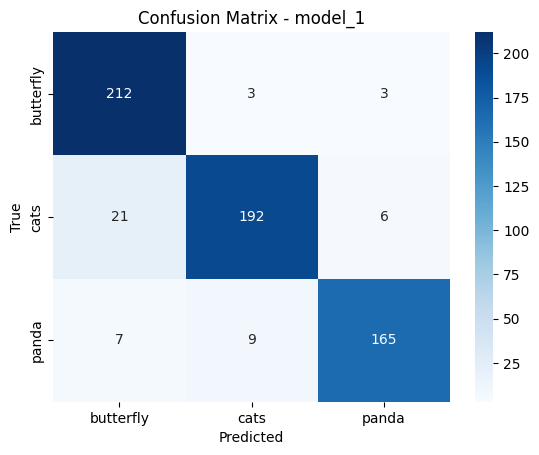

In [9]:
df_results = pd.DataFrame(results)
print("\n=== Perbandingan Model ===")
print(df_results)

# Visualisasi Confusion Matrix dari model terbaik
best_model_idx = df_results['f1_score'].idxmax()
best_model_name = df_results.loc[best_model_idx, 'name']
print(f"\nModel terbaik: {best_model_name}")

from tensorflow.keras.models import load_model
best_model = load_model(f"{best_model_name}.h5")
y_pred_best = best_model.predict(test_generator)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)

conf_matrix = confusion_matrix(test_generator.classes, y_pred_best_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



## 🔍 Visualisasi Confusion Matrix - `model_1`


Confusion matrix di atas menggambarkan performa model\_1 dalam mengklasifikasikan tiga kelas: **butterfly**, **cats**, dan **panda**. Berikut interpretasi dari masing-masing nilai:

| **True Label** | **Predicted as Butterfly** | **Predicted as Cats** | **Predicted as Panda** |
| -------------- | -------------------------- | --------------------- | ---------------------- |
| **Butterfly**  | 212 (✅ benar)              | 3                     | 3                      |
| **Cats**       | 21                         | 192 (✅ benar)         | 6                      |
| **Panda**      | 7                          | 9                     | 165 (✅ benar)          |

### 📌 Penjelasan Detail

* **Butterfly**

  * Sebanyak **212 gambar butterfly** diklasifikasikan dengan benar.
  * **3 gambar butterfly** salah diklasifikasikan sebagai **cats**.
  * **3 gambar butterfly** salah diklasifikasikan sebagai **panda**.

* **Cats**

  * **192 gambar kucing** diklasifikasikan dengan benar.
  * Namun, **21 gambar kucing** salah diklasifikasikan sebagai **butterfly** (ini kesalahan terbanyak).
  * **6 gambar kucing** salah diklasifikasikan sebagai **panda**.

* **Panda**

  * **165 gambar panda** diklasifikasikan dengan benar.
  * **7 gambar panda** salah diklasifikasikan sebagai **butterfly**.
  * **9 gambar panda** salah diklasifikasikan sebagai **cats**.

### ✅ Kesimpulan

* Model\_1 menunjukkan performa yang **sangat baik**, terutama pada kelas **butterfly** dan **panda**, dengan jumlah klasifikasi benar yang tinggi.
* **Kesalahan terbesar** terjadi ketika model mengira gambar **kucing (cats)** sebagai **butterfly** (21 kasus), yang bisa menjadi indikasi bahwa fitur visual kedua kelas tersebut agak mirip menurut model.


## 📊 Hasil Perbandingan Model

### 🥇 Model Terbaik: model_1
Berdasarkan hasil evaluasi terhadap ketiga model, model_1 dipilih sebagai model terbaik karena memiliki nilai f1-score tertinggi yaitu 0.9205. Selain itu, model_1 juga unggul dalam metrik lain seperti:
- Accuracy: 92.07%
- Precision: 92.28%
- Recall: 92.07%

Nilai-nilai tersebut menunjukkan bahwa model_1 memiliki performa klasifikasi yang paling seimbang dan andal dibanding model lainnya.